In [1]:
from dictionary_graph import DictionaryGraph
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import networkx as nx

In [2]:
# Računa matricu sličnosti grafova s matricama susjedstva A i B
# method: iterative ili projector
# - iterative: matrica sličnosti računa se iteriranjem
# - projector: matrica sličnosti računa se preko projektora, za nenegativne matrice A i B
# max_iter: maksimalan broj iteracija za method=iterative
# stop_early: zaustavlja iteriranje za method=iterative ako je norma razlike uzastopnih iteracija manja od epsilon
# epsilon: konstanta za stop_early=True
def similarity_matrix(A, B, method="iterative", max_iter=100, stop_early=True, epsilon=1e-6):
    if method == "iterative":
        Z = np.full((B.shape[0], A.shape[0]), 1, dtype=np.float64)
        AT = A.T
        BT = B.T
        for i in range(max_iter):
            Z2 = Z
            for j in range(2):
                Z = B @ Z @ AT + BT @ Z @ A
                Z /= np.linalg.norm(Z, 'fro')
            if stop_early and np.linalg.norm(Z - Z2, 'fro') < epsilon:
                break
        return Z
    elif method == "projector":
        if issparse(A):
            A = A.toarray()
        if issparse(B):
            B = B.toarray()
        M = np.kron(A, B) + np.kron(A.T, B.T)
        w, V = np.linalg.eigh(M)
        p = np.full(w.shape, w[-1]) # Perronov korijen p
        P = np.hstack((V[:,np.isclose(w, p)], V[:,np.isclose(w, -p)])) # Potprostori od p i -p
        Pi = P @ P.T # Projektor na potprostore
        Z = np.sum(Pi, 0).reshape((B.shape[0], A.shape[0])) # Projekcija vektora jedinica na potprostore
        return Z / np.linalg.norm(Z, 'fro') # Još normiramo

In [3]:
graph = DictionaryGraph('OPTED')
print('Broj vrhova: {}\nBroj bridova: {}'.format(*graph.size()))

Broj vrhova: 106282
Broj bridova: 1315090


In [4]:
def get_synonyms(word, n=10, **kwargs):
    vertices, adjacency_matrix = graph.neighbourhood(word, **kwargs)
    S = pd.DataFrame(similarity_matrix(
        np.array([
            [0, 1, 0],
            [0, 0, 1],
            [0, 0, 0],
        ], dtype=np.float64),
        adjacency_matrix,
    ), index=vertices)
    return S[1].nlargest(n)

In [5]:
methods = [(1, None), (2, None), (3, lambda x: x), (3, np.sqrt)]
for i in range(len(methods)):
    print(f'Metoda {i + 1}')
    print(get_synonyms('disappear', method=methods[i][0], f=methods[i][1]), end='\n\n')

Metoda 1
value
to           0.190090
as           0.187332
a            0.179362
or           0.177176
of           0.172529
the          0.160343
disappear    0.140431
be           0.132365
from         0.127341
at           0.107400
Name: 1, dtype: float64

Metoda 2
value
disappear    0.369223
vanish       0.191113
pass         0.163782
die          0.118671
fade         0.103871
wear         0.098721
faint        0.097857
sail         0.087878
gradually    0.085647
light        0.066490
Name: 1, dtype: float64

Metoda 3
value
evanid         0.579569
vanish         0.015435
disappear      0.015208
faint          0.007551
fade           0.001621
die            0.001493
pass           0.001353
dissipate      0.001344
evanesce       0.001343
disappeared    0.000805
Name: 1, dtype: float64

Metoda 4
value
evanid       0.416420
disappear    0.265977
vanish       0.176820
faint        0.106344
fade         0.100385
die          0.072913
pass         0.063720
eliminate    0.057937
dissipate

In [6]:
def display_synonyms(word, n=10, subgraph=True, **kwargs):
    vertices, adjacency_matrix = graph.neighbourhood(word, **kwargs)
    synonyms = get_synonyms(word, n=n, **kwargs)
    labels = pd.Series(vertices.index, index=vertices.values)
    A = adjacency_matrix.toarray()
    g = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph())
    if subgraph: # podgraf samo sa sinonimima
        indices = list(synonyms.index.map(pd.Series(vertices.index, vertices)))
        g = g.subgraph(indices)
        labels = pd.Series(synonyms.index, index=indices).to_dict()
    else:
        labels = vertices.to_dict()
    print(synonyms)
    plt.figure(figsize=(8,8))
    nx.draw(
        g,
        pos=nx.circular_layout(g),
        with_labels=True,
        labels=labels,
        node_size=6000,
        node_color='white',
        edgecolors='black',
    )

value
faint         0.298059
evanid        0.296512
vanish        0.262841
weak          0.205042
evanescent    0.200979
disappear     0.187038
liable        0.129616
Name: 1, dtype: float64


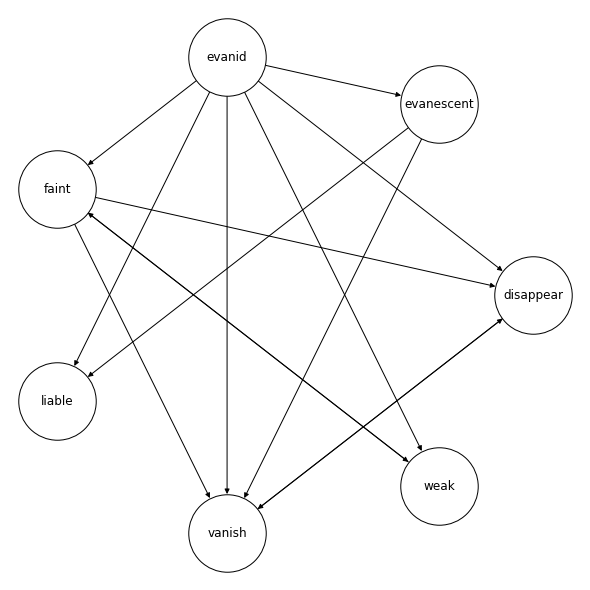

In [7]:
display_synonyms('evanid', method=2)

value
faint         0.298059
evanid        0.296512
vanish        0.262841
weak          0.205042
evanescent    0.200979
disappear     0.187038
liable        0.129616
Name: 1, dtype: float64


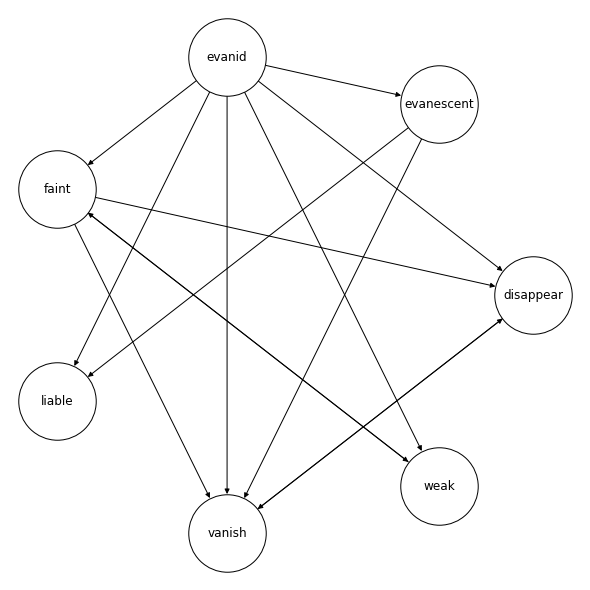

In [8]:
display_synonyms('evanid', method=2, subgraph=False)